
## Preprocesamiento de Datos

In [1]:
# Se importan librerías
import pandas as pd
import numpy as np
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [2]:
# Modelo en español de spaCy
nlp = spacy.load('es_core_news_sm')

# Lectura de los datos
data = pd.read_csv('comentarios.csv', sep=',')
comentarios = ' '.join(data['comentario'])

### Limpieza, tokenización y reducción del vocabulario

In [3]:
# Función para limpieza y tokenización
def limpiar_tokenizar(text):
    # Patrón de expresión regular para tokenización
    pattern = '\w+|:\)|:\(|[^.,;\s]'
    # Tokenización utilizando RegexpTokenizer
    tokenizer = RegexpTokenizer(pattern)
    tokens = tokenizer.tokenize(text)
    # Limpieza de tokens
    stop_words = set(stopwords.words('spanish'))
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    return tokens

In [4]:
# Función para lematizar tokens
def lematizar_texto(tokens):
    lemas = []
    for token in tokens:
        doc = nlp(token)
        lemas.append(doc[0].lemma_)
    return lemas

# Función para stemming tokens
def stem_texto(tokens):
    stemmer = SnowballStemmer('spanish')
    raices = [stemmer.stem(token) for token in tokens]
    return raices

In [5]:
# Se aplican las funciones a data
data['tokens'] = data['comentario'].apply(limpiar_tokenizar)
data['lemas'] = data['tokens'].apply(lematizar_texto)
data['raices'] = data['tokens'].apply(stem_texto)

In [6]:
# Se visualiza data incluyendo tokens, lemas y raices
data.head()

,orden,comentario,tipo,tokens,lemas,raices
0,1,"No les creo nada ,",malo,[creo],[creer],[cre]
1,2,Está bonita la camioneta,bueno,"[bonita, camioneta]","[bonito, camioneta]","[bonit, camionet]"
2,3,Quiero más información,info,"[quiero, información]","[querer, información]","[quier, inform]"
3,4,:( igual el crédito ha de ser muuuucho,malo,"[:(, igual, crédito, ser, muuuucho]","[:(, igual, crédito, ser, muuuucho]","[:(, igual, credit, ser, muuuuch]"
4,5,"Quisiera, más información, pero nadie me respo...",info,"[quisiera, información, nadie, responde]","[querer, información, nadie, responder]","[quis, inform, nadi, respond]"


### División de la muestra en entrenamiento y test

In [7]:
X = data.drop('tipo', axis=1)
y = data['tipo']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

In [8]:
# Cantidad de registros para train y test
print("data_train tiene", data_train.shape[0], "registros y", data_train.shape[1], "columnas.")
print("data_test tiene", data_test.shape[0], "registros y", data_test.shape[1], "columnas.")

data_train tiene 480 registros y 6 columnas.
data_test tiene 120 registros y 6 columnas.


### Distribución del target según muestra, train y test

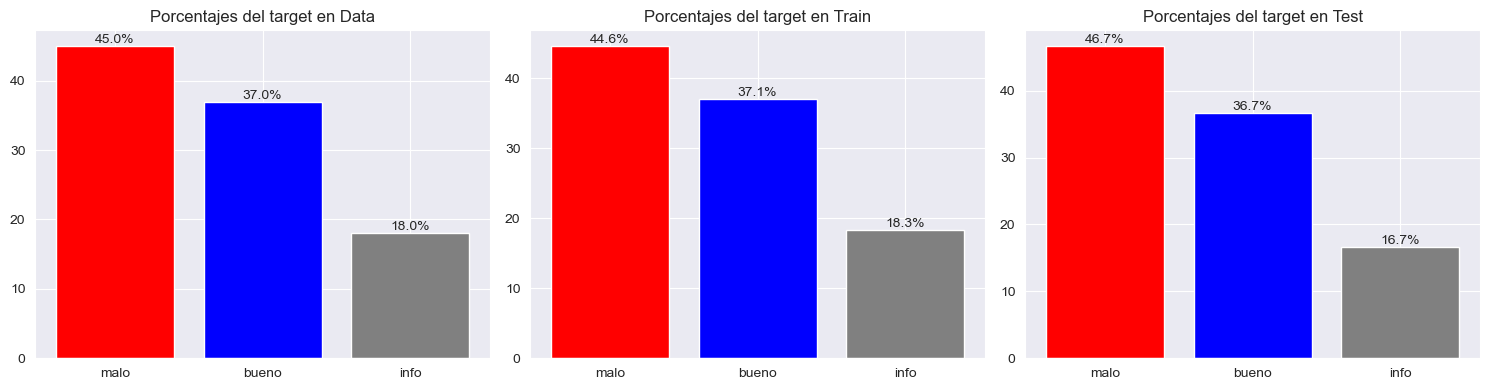

In [9]:
# Calcular porcentajes de muestra
data_total = len(data)
data_counts = data['tipo'].value_counts()
data_porcentaje = data_counts / data_total * 100

# Calcular porcentajes de train
train_total = len(data_train)
train_counts = data_train['tipo'].value_counts()
train_porcentaje = train_counts / train_total * 100

# Calcular porcentajes de test
test_total = len(data_test)
test_counts = data_test['tipo'].value_counts()
test_porcentaje = test_counts / test_total * 100

# Figura, subplots y colores para cada categoría
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
colors = {'malo': 'red', 'bueno': 'blue', 'info': 'gray'}

# Gráfico de barras para muestra
x_data = range(len(data_porcentaje))
ax1.bar(x_data, data_porcentaje, align='center', color=[colors.get(t, 'gray') for t in data_porcentaje.index])
ax1.set_title('Porcentajes del target en Data')
ax1.set_xticks(x_data)
ax1.set_xticklabels(data_porcentaje.index)
for i, percentage in enumerate(data_porcentaje):
    ax1.text(i, percentage, f'{percentage:.1f}%', ha='center', va='bottom')

# Gráfico de barras para train
x_train = range(len(train_porcentaje))
ax2.bar(x_train, train_porcentaje, align='center', color=[colors.get(t, 'gray') for t in train_porcentaje.index])
ax2.set_title('Porcentajes del target en Train')
ax2.set_xticks(x_train)
ax2.set_xticklabels(train_porcentaje.index)
for i, percentage in enumerate(train_porcentaje):
    ax2.text(i, percentage, f'{percentage:.1f}%', ha='center', va='bottom')

# Gráfico de barras para test
x_test = range(len(test_porcentaje))
ax3.bar(x_test, test_porcentaje, align='center', color=[colors.get(t, 'gray') for t in test_porcentaje.index])
ax3.set_title('Porcentajes del target en Test')
ax3.set_xticks(x_test)
ax3.set_xticklabels(test_porcentaje.index)
for i, percentage in enumerate(test_porcentaje):
    ax3.text(i, percentage, f'{percentage:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Representación Vectorial

In [10]:
# Se analizan los tipos de datos para adaptarse al modelo
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   orden       600 non-null    int64 
 1   comentario  600 non-null    object
 2   tipo        600 non-null    object
 3   tokens      600 non-null    object
 4   lemas       600 non-null    object
 5   raices      600 non-null    object
dtypes: int64(1), object(5)
memory usage: 28.2+ KB


In [11]:
# Convertir object a string
data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x))
data['lemas'] = data['lemas'].apply(lambda x: ' '.join(x))
data['raices'] = data['raices'].apply(lambda x: ' '.join(x))

# Unir
data['texto_combinado'] = data['tokens'] + ' ' + data['lemas'] + ' ' + data['raices']

In [12]:
data.head()

,orden,comentario,tipo,tokens,lemas,raices,texto_combinado
0,1,"No les creo nada ,",malo,creo,creer,cre,creo creer cre
1,2,Está bonita la camioneta,bueno,bonita camioneta,bonito camioneta,bonit camionet,bonita camioneta bonito camioneta bonit camionet
2,3,Quiero más información,info,quiero información,querer información,quier inform,quiero información querer información quier in...
3,4,:( igual el crédito ha de ser muuuucho,malo,:( igual crédito ser muuuucho,:( igual crédito ser muuuucho,:( igual credit ser muuuuch,:( igual crédito ser muuuucho :( igual crédito...
4,5,"Quisiera, más información, pero nadie me respo...",info,quisiera información nadie responde,querer información nadie responder,quis inform nadi respond,quisiera información nadie responde querer inf...


In [13]:
# Realizar la representación vectorial
tfidf = TfidfVectorizer(token_pattern=r'\w+|:\)|:\(|[^.,;\s]')
tfidf_X = tfidf.fit_transform(data['texto_combinado'])

# Transformar target a valores
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['tipo'])

In [14]:
feature_names = tfidf.get_feature_names_out()

# Se crea un DataFrame para mostrar la matriz tf-idf
tfidf_df = pd.DataFrame(np.round(tfidf_X.toarray(), 3), columns=feature_names)

print(tfidf_df)
print('\nLa forma de la matriz TF-IDF es:', tfidf_X.shape)

       !    $    %    (    )    +  000  000km    1   10  ...   ús    …    ❣  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  ...  0.0  0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  ...  0.0  0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  ...  0.0  0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  ...  0.0  0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  ...  0.0  0.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...    ...  ...  ...  ...  ...  ...  ...   
595  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  ...  0.0  0.0  0.0   
596  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  ...  0.0  0.0  0.0   
597  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  ...  0.0  0.0  0.0   
598  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  ...  0.0  0.0  0.0   
599  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  0.0  0.0  ...  0.0  0.0  0.0   

       ❤    💯    😅    😍    🙂    🤣    🥰  
0    0.0  

### Random Forest

Se implementará una estrategia combinada que integre el modelo Random Forest con GridSearchCV y k-Folds para asegurar el máximo rendimiento. Al ajustar los hiperparámetros y validar el modelo, se garantiza una clasificación precisa y con capacidad de generalización en diversos escenarios. 

In [15]:
# Se divide el conjunto de datos vectorizado en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(tfidf_X, y_encoded, test_size=0.2, random_state=42)

In [16]:
# Se crea el modelo Random Forest con el que trabajaremos
random_forest_model = RandomForestClassifier()

# Se definen los hiperparámetros a ajustar con GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30]
}

# Se crea el objeto GridSearchCV con k-Fold Cross Validation
grid_search = GridSearchCV(random_forest_model, param_grid, cv=5, scoring='accuracy')

# Se realiza Validación cruzada con GridSearchCV para obtener el mejor modelo con los mejores hiperparámetros
grid_search.fit(tfidf_X, y_encoded)

# Mejores hiperparámetros
best_random_forest_model = grid_search.best_estimator_

# Se realizan predicciones en el conjunto completo utilizando el mejor modelo
y_pred_cv = cross_val_predict(best_random_forest_model, tfidf_X, y_encoded, cv=5)

# Matriz de confusión
confusion = confusion_matrix(y_encoded, y_pred_cv)

### Resultados

In [17]:
# Métricas de desempeño
accuracy = accuracy_score(y_encoded, y_pred_cv)
precision = precision_score(y_encoded, y_pred_cv, average='weighted')
recall = recall_score(y_encoded, y_pred_cv, average='weighted')
f1 = f1_score(y_encoded, y_pred_cv, average='weighted')

# Resultados
print("Matriz de Confusión:")
print(confusion)
print("\nAcuracidad: {:.2f}%".format(accuracy * 100))
print("Precisión: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Puntuación F1: {:.2f}%".format(f1 * 100))

Matriz de Confusión:
[[222   0   0]
 [  0 108   0]
 [  0   0 270]]

Acuracidad: 100.00%
Precisión: 100.00%
Recall: 100.00%
Puntuación F1: 100.00%


In [18]:
# Informe de clasificación
class_names = label_encoder.classes_
report = classification_report(y_encoded, y_pred_cv, target_names=class_names)
print("Informe de Clasificación:")
print(report)

Informe de Clasificación:
              precision    recall  f1-score   support

       bueno       1.00      1.00      1.00       222
        info       1.00      1.00      1.00       108
        malo       1.00      1.00      1.00       270

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


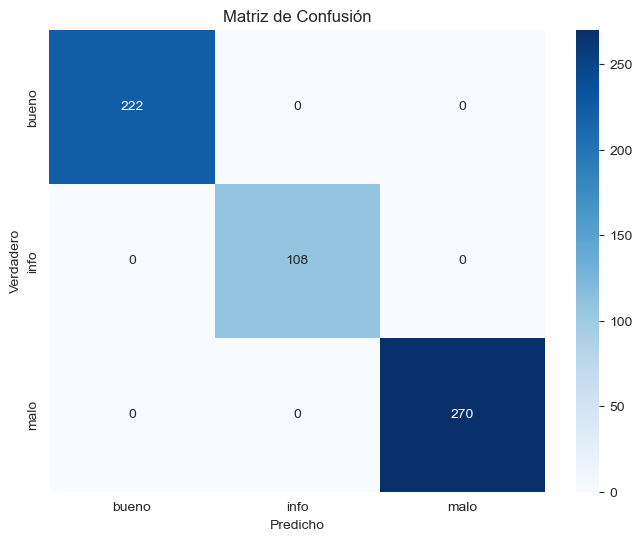

In [19]:
# Heatmap para matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión')
plt.show()

### Conclusiones

El modelo de clasificación Random Forest ha logrado un rendimiento perfecto en la clasificación de comentarios. La matriz de confusión muestra clasificaciones precisas sin errores. Esto sugiere una excelente capacidad para generalizar en este conjunto de datos. Se debería explorar su rendimiento en datos más grandes y variados para una evaluación completa.